In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiclassifier as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
88,5.6,3.0,4.1,1.3,Iris-versicolor
146,6.3,2.5,5.0,1.9,Iris-virginica
108,6.7,2.5,5.8,1.8,Iris-virginica
60,5.0,2.0,3.5,1.0,Iris-versicolor
120,6.9,3.2,5.7,2.3,Iris-virginica
...,...,...,...,...,...
0,5.1,3.5,1.4,0.2,Iris-setosa
24,4.8,3.4,1.9,0.2,Iris-setosa
142,5.8,2.7,5.1,1.9,Iris-virginica
42,4.4,3.2,1.3,0.2,Iris-setosa


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTEMultiDecisionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    discretize_continuous=False
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

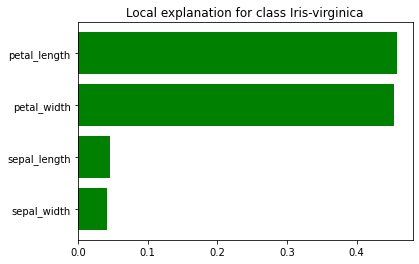

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0, 0, 1]
[0, 0, 1]
[0.0, 0.0, 1.0]


In [10]:
explanation.get_fidelity_loss_on_explanation()


0.0

In [11]:
explanation.get_fidelity_loss_on_generated_data()


0.0

In [12]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.4573875518386161),
 (3, 0.4540258089937977),
 (0, 0.04625534130734399),
 (1, 0.04233129786024216)]

In [13]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(3, 0.46994356185333513),
 (2, 0.4397551686502728),
 (1, 0.04880313595509098),
 (0, 0.041498133541301115)]

In [14]:
explanation.as_map()

{0: [(2, 0.4634729799669396),
  (3, 0.39975913343105907),
  (0, 0.09032098112806579),
  (1, 0.046446905473935554)],
 1: [(3, 0.46994356185333513),
  (2, 0.4397551686502728),
  (1, 0.04880313595509098),
  (0, 0.041498133541301115)],
 2: [(2, 0.4573875518386161),
  (3, 0.4540258089937977),
  (0, 0.04625534130734399),
  (1, 0.04233129786024216)]}

In [15]:
explainer.discretizer.names

AttributeError: 'NoneType' object has no attribute 'names'

In [ ]:
explainer.discretizer.maxs

Update some attributes to see if probabilities would change

In [ ]:
top_features = explanation.as_map()[predicted_label_id]
top_features